In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read in RVs
df = pd.read_csv('../website/uploading_RC/data/targets/LHS_3154/results_example/LHS_3154_rv_bin.csv')
df

,bjd,rv,e_rv
0,2.458872e+06,-1.600991,6.437814
1,2.458894e+06,22.998271,25.434414


Text(0, 0.5, 'RV [m/s]')

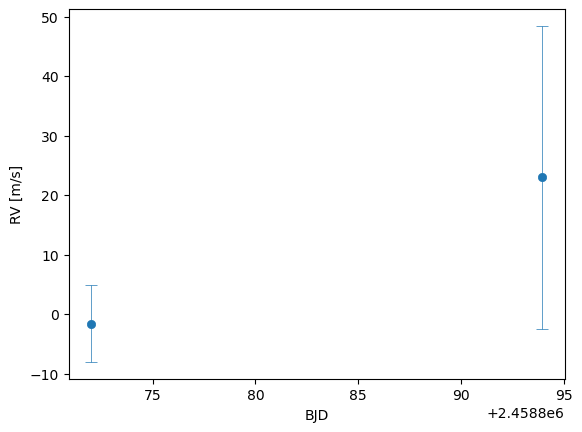

In [8]:
# Very minimal Example plot for now, need to update with the full RV extraction + periodogram etc.

fig, ax = plt.subplots()
ax.errorbar(df.bjd,df.rv,df.e_rv,marker='o',lw=0,mew=0.5,capsize=4,elinewidth=0.5)
ax.set_xlabel("BJD")
ax.set_ylabel('RV [m/s]')